In [1]:
# Importing Dependencies
import numpy as np
import pandas as pd
import sys
import os
import warnings
from datetime import datetime
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score,f1_score,log_loss,recall_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")
#Setting Up matplotlib
%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100

In [2]:
df = pd.read_csv("sales-of-shampoo-over-a-three-ye.csv")

In [3]:
# Checking Basic information available from dataset
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Month                                      37 non-null     object 
 1   Sales of shampoo over a three year period  36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 720.0+ bytes


In [4]:
df['Month'] = "2018-" + df['Month']
df = df[:-1]

In [5]:
df.Month = pd.to_datetime(df.Month, format='%Y-%m-%d',errors = 'coerce')

  Month  Sales of shampoo over a three year period
0  1-01                                      266.0
1  1-02                                      145.9
2  1-03                                      183.1
3  1-04                                      119.3
4  1-05                                      180.3


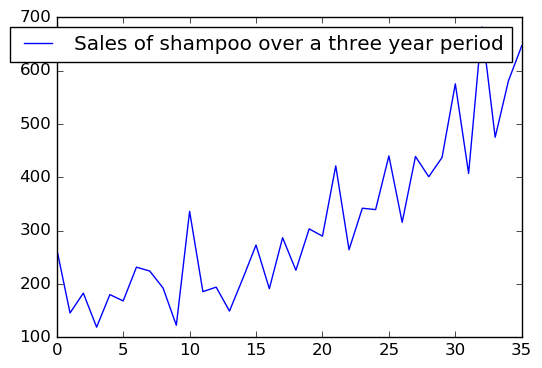

In [6]:
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = pd.read_csv("sales-of-shampoo-over-a-three-ye.csv")
# , header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [7]:
split_date = 20                                
train = df.loc[:20].copy()
test = df.loc[21:].copy()

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Month
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
train_x, train_y = create_features(df, label='Sales of shampoo over a three year period')
test_x, test_y = create_features(df, label='Sales of shampoo over a three year period')

In [10]:
reg = xgb.XGBRegressor(n_estimators=1000)
t1=datetime.now()
reg.fit(train_x, train_y,
        eval_set=[(train_x, train_y), (test_x, test_y )],
        early_stopping_rounds=50,
       verbose=False)
t2=datetime.now()
execution_time_xgb = t2-t1
xgb_train_time = t2-t1
t3 = datetime.now()
y_pred = reg.predict(test_x)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(r2_score(y_pred,test_y),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)

[04:34:07] WARNING: /opt/anaconda/conda-bld/xgboost-base_1580563807216/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy score =  100.0 %
Execution time =  0:00:00.201964
Prediction time =  0:00:00.002391


In [11]:
params = {
   'boosting_type': 'gbdt',
   'objective': 'regression',
   'random_state': 6,
   'feature_fraction': 0.09,
   'subsample':  0.25,
   'n_jobs': 4
}
num_round=20
train_x_lgb= train_x
train_y_lgb = train_y
t1=datetime.now()
lgbr = lgb.LGBMRegressor(**params)
model = lgbr.fit(train_x_lgb,y=train_y_lgb)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3=datetime.now()
y_pred = model.predict(test_x)
t4=datetime.now()
accuracy_lgbm = round(r2_score(test_y,y_pred),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  -0.0 %
Execution time =  0:00:00.009620
Prediction time =  0:00:00.002268


In [13]:
#snapboost implementation
from pai4sk import BoostingMachine

In [25]:
booster = BoostingMachine(objective='mse', num_round=5, min_max_depth=1, max_max_depth=1,
                             learning_rate=0.1, random_state=42, use_gpu=False, n_threads=1)
#use mse/logloss not sure what to use
t1=datetime.now()
booster.fit(train_x.to_numpy(), train_y.to_numpy())
t2=datetime.now()
execution_time_snap_boost = t2-t1
t3 = datetime.now()
ypred = booster.predict(test_x.to_numpy())
t4 = datetime.now()
accuracy_snap_boost = round(r2_score(test_y,y_pred),2)
#check this line for error not
#roc_auc_score was showing some sort of error so i changed it 
# maybe 0% is coming because of this
print("Accuracy score = ",accuracy_snap_boost*100,"%")
print("Execution time = ",execution_time_snap_boost)
print("Prediction time = ",t4-t3)
snap_boost_train_time = t2-t1

Accuracy score =  -0.0 %
Execution time =  0:00:00.008859
Prediction time =  0:00:00.000427


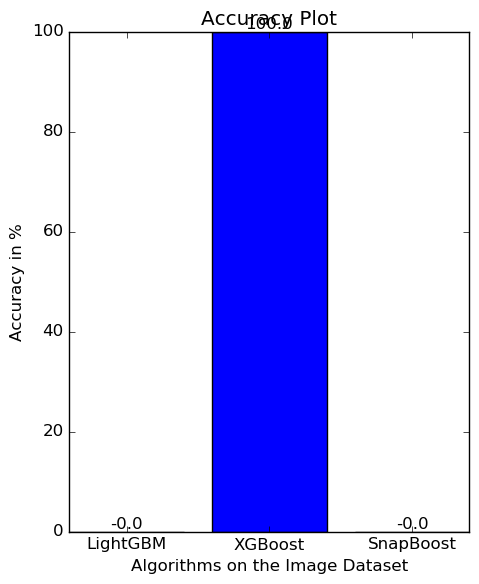

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Image Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

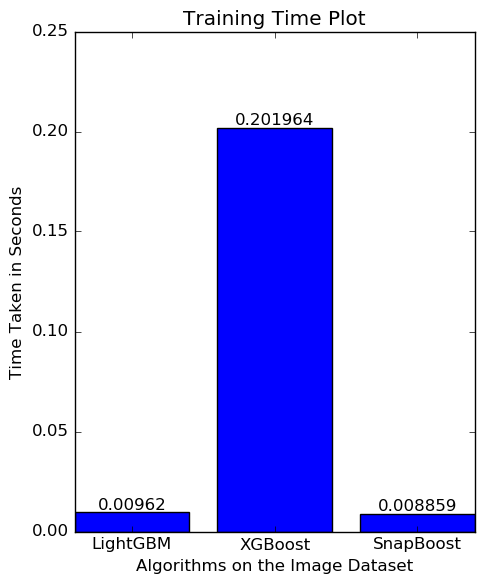

In [27]:
lg = float(str(lgbm_train_time)[5:])
sb = float(str(snap_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
training_time = [lg,xgb,sb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Image Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()